In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K

from sklearn.model_selection import KFold
from keras.models import Model, Sequential
from keras import layers
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [6]:
from ipynb.fs.full.DatasetManage import read_and_store_data
from ipynb.fs.full.FeatureExtraction import feature_extraction
from ipynb.fs.full.ClassificationPerformanceIndexes import classificationPerformanceIndexes, printClassificationPerformanceIndexes
from ipynb.fs.full.ClassificationMethods import CompleteLSTM

Parameter

In [7]:
perfInd = ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1 Score', 'MCC', 'Kappa', 'Time']
channels = ['FP1-F7', 'F7-T7','T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'seizure']

dataset = 'CHB_MIT'
csvImportFile = 'CHB.csv'
csvExportFile = 'CHB.csv'
sample_rate = 256
time_window = 2
step = time_window * sample_rate

test_ratio = 0.3

pca_tolerance = 0.9

undersampling_rate = 0.2

oversampling_neighbors = 11

k_fold = 5

csvAverageFile = 'Features.csv'

batch = 10
epochs = 100
dropout_percentage = 0.2
loss_function = 'mean_squared_error'
metric = 'accuracy'

Create Training and Test Data

In [8]:
def trainTestData (features, test_ratio, k_fold, perfInd):
    x = features.loc[:, features.columns != 'seizure']
    y = features['seizure']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_ratio, shuffle = True)
    results = pd.DataFrame(columns = perfInd)
    kf = KFold(n_splits = k_fold, shuffle = True)
    return x_train, x_test, y_train, y_test, results, kf

Create training and validation and test data

In [28]:
def trainTestData_2 (features, perfInd):
    x = features.loc[:, features.columns != 'seizure']
    y = features['seizure']
    x_1, x_test, y_1, y_test = train_test_split(x, y, test_size = 0.3, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_1, y_1, test_size=0.2, random_state=42)
    results = pd.DataFrame(columns = perfInd)
    return x_train, x_test, y_train, y_test, x_val, y_val, results

Read and Store Data

In [ ]:
print('Reading data from', csvImportFile)
df = pd.read_csv(csvImportFile, delimiter = ',', header = 0)

Feature Extraction 

In [10]:
# ft = feature_extraction(df, sample_rate, step, pca_tolerance, undersampling_rate, oversampling_neighbors)

Train and Test process

In [29]:
ft = pd.read_csv(csvAverageFile, delimiter = ',', header = 0)

Dataset splitting with K-fold validation

In [ ]:
x_train, x_test, y_train, y_test, results, kf = trainTestData (ft, test_ratio, k_fold, perfInd)

x_train = np.reshape(x_train.values, (x_train.shape[0], 1, x_train.shape[1]))
y_train = y_train.values.astype(int)
x_test = np.reshape(x_test.values, (x_test.shape[0], 1, x_test.shape[1]))
y_test = y_test.values.astype(int)

print(np.shape(x_train))
print(np.shape(y_train))


Dataset splitting with validation set

In [31]:
x_train, x_test, y_train, y_test, x_val, y_val, results = trainTestData_2 (ft, perfInd)

x_train = np.reshape(x_train.values, (x_train.shape[0], 1, x_train.shape[1]))
y_train = y_train.values.astype(int)
x_val = np.reshape(x_test.values, (x_test.shape[0], 1, x_test.shape[1]))
y_val = y_test.values.astype(int)
x_test = np.reshape(x_test.values, (x_test.shape[0], 1, x_test.shape[1]))
y_test = y_test.values.astype(int)

print(np.shape(x_train))
print(np.shape(y_train))

(313, 1, 86)
(313,)


In [13]:
model = Sequential()
model.add(layers.Conv1D(8, 24, activation='relu', input_shape=(None, x_train.shape[-1])))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(8, 12, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(8, 6, activation='relu'))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(1))


history = model.fit(x_train,
                    steps_per_epoch=500,
                    epochs=2)


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

1D Convolutional Model

In [ ]:
# Definizione dell'architettura della rete neurale

num_classes = 2
input_channels = 87

model = tf.keras.Sequential()
model.add(layers.Conv1D(8, 24, activation='relu', input_shape=(1, input_channels)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(8, 12, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(8, 6, activation='relu'))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compilazione del modello
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# model.compile(optimizer='rmsprop', loss='mae')

# Training 

# X_train = X_train.reshape(-1, input_length, input_channels)

num_epochs = 20
batch_size = 8
model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size)

# Evaluation of the model

# X_test = X_test.reshape(-1, input_length, input_channels)
loss, accuracy = model.evaluate(x_test, y_test, batch_size=batch_size)

# Utilizzo del modello per effettuare predizioni
predictions = model.predict(x_test)


ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv1d_3. Consider increasing the input size. Received input shape [None, 1, 87] which would produce output shape with a zero or negative value in a dimension.

1D CN

In [ ]:
model = Sequential()
model.add(layers.Conv1D(8, 24, activation='relu', input_shape=(None, x_train.shape[-1])))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(8, 12, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(8, 6, activation='relu'))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mae')
history = model.fit(x_train,
                    y_train,
                    steps_per_epoch=350,
                    epochs=20)

GRU

In [ ]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, x_train.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mae', metrics=['accuracy'])
history = model.fit(x_train,
                    y_train,
                    steps_per_epoch=500,
                    epochs=20)


Epoch 1/20
500/500 [==============================] - 3s 1ms/step - loss: 0.3207 - accuracy: 0.8400
Epoch 2/20
500/500 [==============================] - 1s 1ms/step - loss: 0.1916 - accuracy: 0.9240
Epoch 3/20
500/500 [==============================] - 1s 1ms/step - loss: 0.1312 - accuracy: 0.9680
Epoch 4/20
500/500 [==============================] - 1s 1ms/step - loss: 0.1270 - accuracy: 0.9560
Epoch 5/20
500/500 [==============================] - 1s 1ms/step - loss: 0.1135 - accuracy: 0.9680
Epoch 6/20
500/500 [==============================] - 1s 1ms/step - loss: 0.0990 - accuracy: 0.9700
Epoch 7/20
500/500 [==============================] - 1s 1ms/step - loss: 0.0953 - accuracy: 0.9660
Epoch 8/20
500/500 [==============================] - 1s 1ms/step - loss: 0.0900 - accuracy: 0.9620
Epoch 9/20
500/500 [==============================] - 1s 1ms/step - loss: 0.0814 - accuracy: 0.9740
Epoch 10/20
500/500 [==============================] - 1s 2ms/step - loss: 0.0813 - accuracy: 0.9620

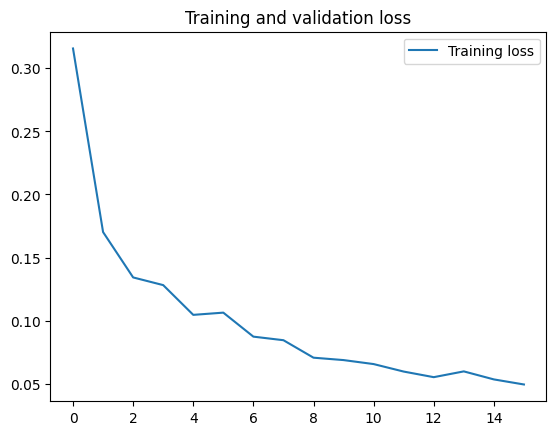

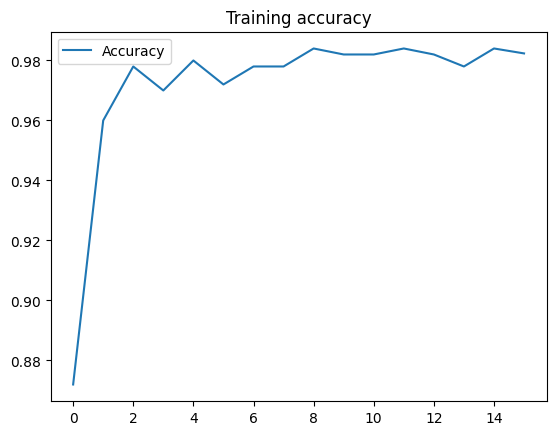

In [ ]:
loss = history.history['loss']
acc = history.history['accuracy']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.title('Training loss')
plt.legend()

plt.show()


plt.figure()

plt.plot(epochs, acc, label='Accuracy')
plt.title('Training accuracy')
plt.legend()

plt.show()

Dropout

In [ ]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, x_train.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mae')
history = model.fit(x_train,
                    y_train,
                    steps_per_epoch=500,
                    epochs=40)

# Plot 

loss = history.history['loss']
acc = history.history['acc']

epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, loss, label='Training accuracy')
plt.title('Training loss and accuracy with dropout')
plt.legend()

plt.show()

LSTM 

In [ ]:
lstm_units = 128
dense_units = 32  

CompleteLSTM(x_train, x_test, y_train, y_test, results, ft, kf, perfInd, epochs, batch, lstm_units, dense_units, dropout_percentage, loss_function, metric)

Vanilla RNN

Training

Epoch 1/150
40/40 [==============================] - 1s 7ms/step - loss: 0.6498 - accuracy: 0.6709 - val_loss: 0.4767 - val_accuracy: 0.7917
Epoch 2/150
40/40 [==============================] - 0s 3ms/step - loss: 0.4001 - accuracy: 0.8466 - val_loss: 0.3663 - val_accuracy: 0.8512
Epoch 3/150
40/40 [==============================] - 0s 3ms/step - loss: 0.3087 - accuracy: 0.8818 - val_loss: 0.3087 - val_accuracy: 0.8750
Epoch 4/150
40/40 [==============================] - 0s 3ms/step - loss: 0.2592 - accuracy: 0.9105 - val_loss: 0.2805 - val_accuracy: 0.8929
Epoch 5/150
40/40 [==============================] - 0s 3ms/step - loss: 0.2304 - accuracy: 0.9201 - val_loss: 0.2605 - val_accuracy: 0.8929
Epoch 6/150
40/40 [==============================] - 0s 3ms/step - loss: 0.2089 - accuracy: 0.9297 - val_loss: 0.2461 - val_accuracy: 0.8929
Epoch 7/150
40/40 [==============================] - 0s 5ms/step - loss: 0.1942 - accuracy: 0.9393 - val_loss: 0.2336 - val_accuracy: 0.9048
Epoch 8/150
4

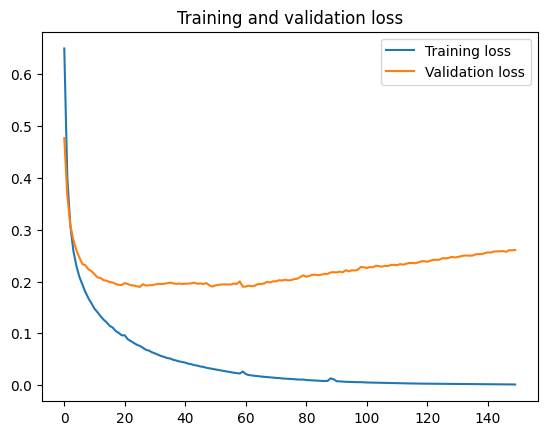

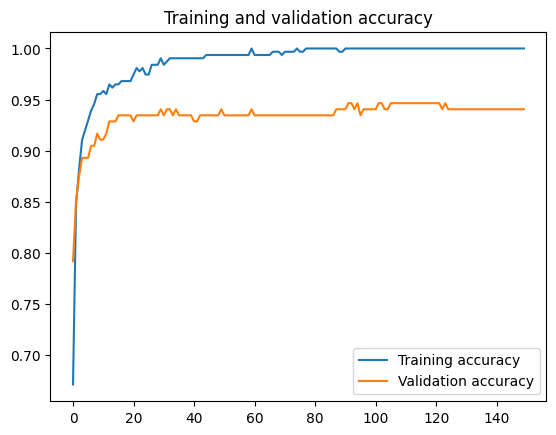

In [37]:
# Definizione del modello RNN

model = Sequential()
model.add(SimpleRNN(32, input_shape=(None, x_train.shape[-1])))  # "timesteps" rappresenta il numero di istanti temporali nel segnale EEG, "features" è il numero di caratteristiche per ciascun istante temporale
model.add(Dense(1, activation='sigmoid'))

# Compilazione del modello
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Addestramento del modello
history = model.fit(x_train, y_train, epochs=150, batch_size=8, validation_data=(x_val, y_val))

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(train_loss))

plt.figure()
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()


Evaluation of the model

6/6 [==============================] - 0s 2ms/step - loss: 0.2608 - accuracy: 0.9405
Test Loss: 0.2607915699481964
Test Accuracy: 0.9404761791229248


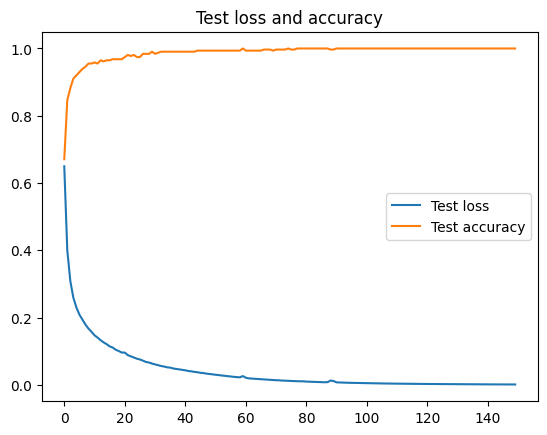

In [40]:
# Valutazione del modello
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

test_loss = history.history['loss']
test_acc = history.history['accuracy']

epochs = range(len(test_loss))

plt.figure()
plt.plot(epochs, test_loss, label='Test loss')
plt.plot(epochs, test_acc, label='Test accuracy')
plt.title('Test loss and accuracy')
plt.legend()

plt.show()

Dropout to prevent overfitting

Epoch 1/200
40/40 [==============================] - 1s 7ms/step - loss: 0.7037 - accuracy: 0.5591 - val_loss: 0.5161 - val_accuracy: 0.7679
Epoch 2/200
40/40 [==============================] - 0s 3ms/step - loss: 0.4640 - accuracy: 0.8019 - val_loss: 0.3713 - val_accuracy: 0.8571
Epoch 3/200
40/40 [==============================] - 0s 3ms/step - loss: 0.3388 - accuracy: 0.8786 - val_loss: 0.3013 - val_accuracy: 0.8929
Epoch 4/200
40/40 [==============================] - 0s 3ms/step - loss: 0.2779 - accuracy: 0.9010 - val_loss: 0.2638 - val_accuracy: 0.8929
Epoch 5/200
40/40 [==============================] - 0s 3ms/step - loss: 0.2421 - accuracy: 0.9201 - val_loss: 0.2377 - val_accuracy: 0.9167
Epoch 6/200
40/40 [==============================] - 0s 3ms/step - loss: 0.2240 - accuracy: 0.9265 - val_loss: 0.2221 - val_accuracy: 0.9286
Epoch 7/200
40/40 [==============================] - 0s 3ms/step - loss: 0.2124 - accuracy: 0.9233 - val_loss: 0.2102 - val_accuracy: 0.9286
Epoch 8/200
4

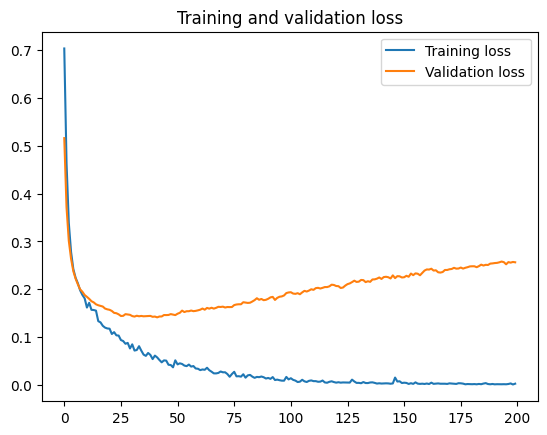

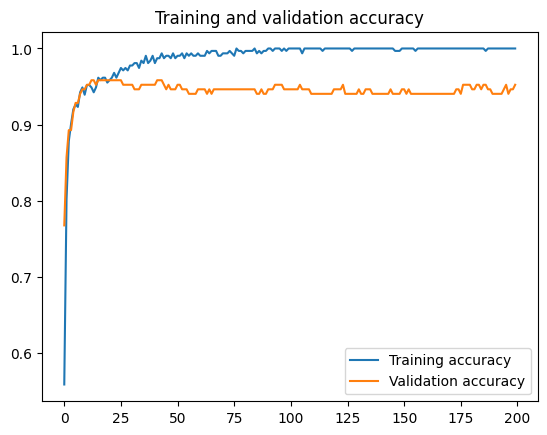

In [56]:
# Modello Vanilla RNN con dropout

model = Sequential()
model.add(SimpleRNN(32, input_shape=(None, x_train.shape[-1])))  # "timesteps" rappresenta il numero di istanti temporali nel segnale EEG, "features" è il numero di caratteristiche per ciascun istante temporale
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compilazione del modello
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Addestramento del modello
history = model.fit(x_train, y_train, epochs=200, batch_size=8, validation_data=(x_val, y_val))

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(train_loss))

plt.figure()
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

Evaluation of the model after dropout

6/6 [==============================] - 0s 3ms/step - loss: 0.1696 - accuracy: 0.9583
Test Loss: 0.1696280986070633
Test Accuracy: 0.9583333134651184


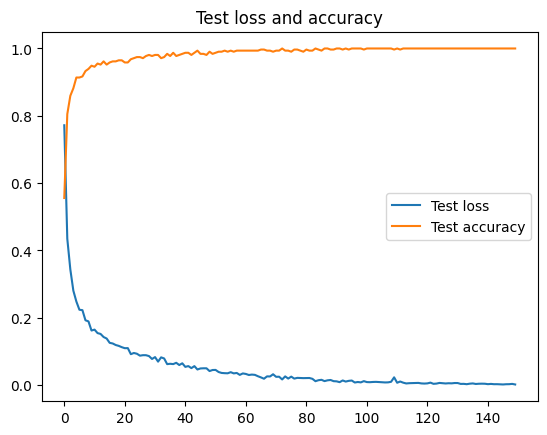

In [42]:
# Valutazione del modello
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

test_loss = history.history['loss']
test_acc = history.history['accuracy']

epochs = range(len(test_loss))

plt.figure()
plt.plot(epochs, test_loss, label='Test loss')
plt.plot(epochs, test_acc, label='Test accuracy')
plt.title('Test loss and accuracy')
plt.legend()

plt.show()

Early stopping

Epoch 1/200
40/40 [==============================] - 1s 7ms/step - loss: 0.5715 - accuracy: 0.6997 - val_loss: 0.4064 - val_accuracy: 0.8452
Epoch 2/200
40/40 [==============================] - 0s 3ms/step - loss: 0.3896 - accuracy: 0.8530 - val_loss: 0.3210 - val_accuracy: 0.8631
Epoch 3/200
40/40 [==============================] - 0s 4ms/step - loss: 0.3200 - accuracy: 0.8818 - val_loss: 0.2828 - val_accuracy: 0.8929
Epoch 4/200
40/40 [==============================] - 0s 4ms/step - loss: 0.2631 - accuracy: 0.9042 - val_loss: 0.2600 - val_accuracy: 0.8929
Epoch 5/200
40/40 [==============================] - 0s 6ms/step - loss: 0.2482 - accuracy: 0.9137 - val_loss: 0.2396 - val_accuracy: 0.9048
Epoch 6/200
40/40 [==============================] - 0s 5ms/step - loss: 0.2183 - accuracy: 0.9265 - val_loss: 0.2261 - val_accuracy: 0.9048
Epoch 7/200
40/40 [==============================] - 0s 4ms/step - loss: 0.1946 - accuracy: 0.9425 - val_loss: 0.2147 - val_accuracy: 0.9167
Epoch 8/200
4

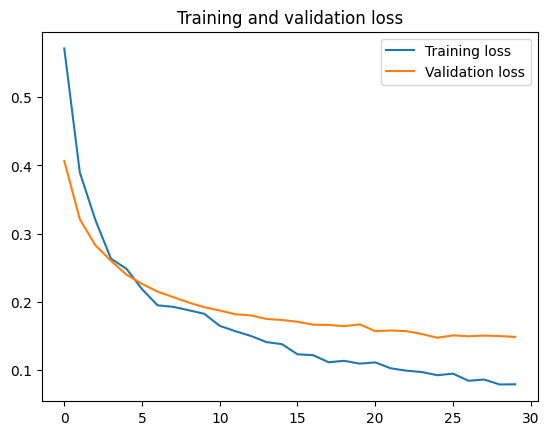

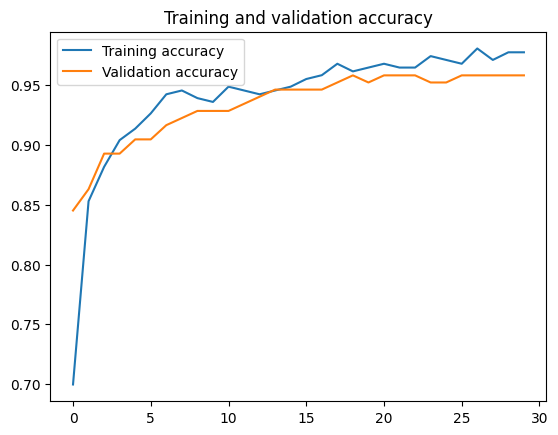

In [54]:
# Modello Vanilla RNN con dropout e early stopping

model = Sequential()
model.add(SimpleRNN(32, input_shape=(None, x_train.shape[-1])))  # "timesteps" rappresenta il numero di istanti temporali nel segnale EEG, "features" è il numero di caratteristiche per ciascun istante temporale
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compilazione del modello
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Definizione dell'early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Addestramento del modello con early stopping
history = model.fit(x_train, y_train, epochs=200, batch_size=8, validation_data=(x_val, y_val), callbacks=[early_stopping])

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(train_loss))

plt.figure()
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()



Evaluation of the model with early stopping

6/6 [==============================] - 0s 2ms/step - loss: 0.1470 - accuracy: 0.9524
Test Loss: 0.14699582755565643
Test Accuracy: 0.9523809552192688


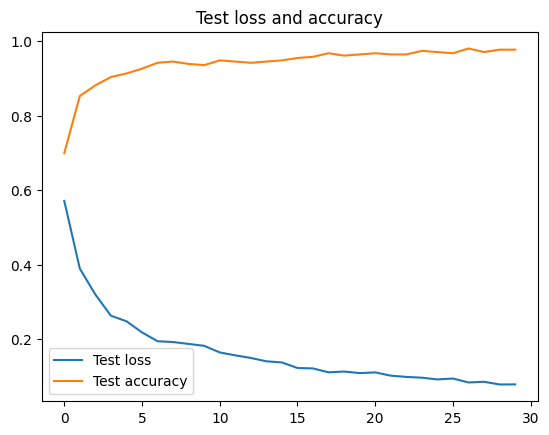

In [55]:
# Valutazione del modello
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

test_loss = history.history['loss']
test_acc = history.history['accuracy']

epochs = range(len(test_loss))

plt.figure()
plt.plot(epochs, test_loss, label='Test loss')
plt.plot(epochs, test_acc, label='Test accuracy')
plt.title('Test loss and accuracy')
plt.legend()

plt.show()